# WNTR Demo

#### Import python packages, including WNTR

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pylab as plt
import wntr

np.random.seed(12345)

#### Create a water network model using an EPANET inp file

In [2]:
inp_file = '../networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

#### Define earthquake epicenter, magnitude, and depth

In [3]:
epicenter = (200,150) # x,y location
magnitude = 5 # Richter scale
depth = 10000 # m, shallow depth

#### Plot location on the network

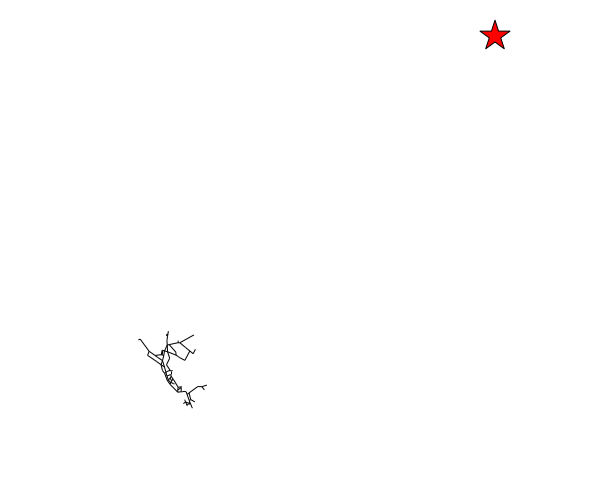

In [4]:
wntr.network.draw_graph(wn, node_size=0, figsize=(10,8), dpi=100)
plt.hold('True')
plt.scatter(epicenter[0], epicenter[1], s = 1000, c = 'r', marker='*', zorder=2)

#### Generate the earthquake scenario

In [5]:
#This scenario assumes uniform pipe and soil type throughout the network.  These parameters can be set for individual pipes
#PGA = 0.001 g (0.01 m/s2) – perceptible by people
#PGA = 0.02  g (0.2  m/s2) – people lose their balance
#PGA = 0.50  g (5 m/s2) – very high; well-designed buildings can survive if the duration is short
#Repair rate of 1/km (0.001/m) has been suggested as an upper bound

earthquake = wntr.scenario.Earthquake(epicenter, magnitude, depth)
earthquake.generate(wn, coordinate_scale=500, correct_length=False)

print "Min, Max, Average PGA: " + str(np.round(np.min(earthquake.pga.values()),2)) + ", " + str(np.round(np.max(earthquake.pga.values()),2)) + ", " + str(np.round(np.mean(earthquake.pga.values()),2)) + " m/s2"
print "Min, Max, Average repair rate: " + str(np.round(np.min(earthquake.repair_rate.values()),5)) + ", " + str(np.round(np.max(earthquake.repair_rate.values()),5)) + ", " + str(np.round(np.mean(earthquake.repair_rate.values()),5)) + " per m"
print "Number of pipe failures: " + str(len(earthquake.pipes_to_leak))

Min, Max, Average PGA: 0.09, 0.1, 0.09 m/s2
Min, Max, Average repair rate: 3e-05, 6e-05, 5e-05 per m
Number of pipe failures: 10


#### Plot peak ground acceleration

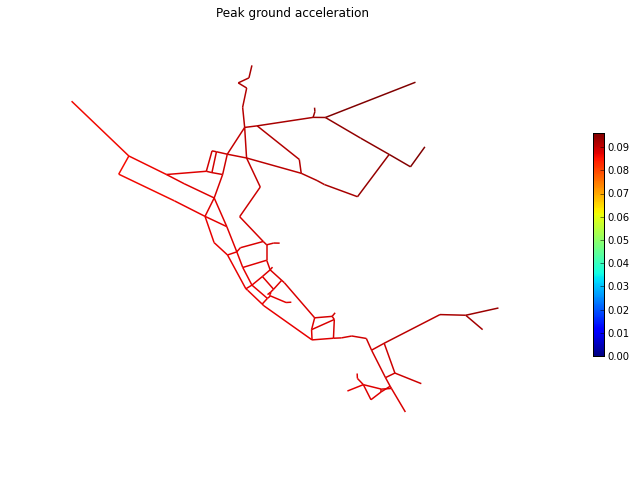

In [6]:
wntr.network.draw_graph(wn, link_attribute=earthquake.pga, node_size=0, link_width=1.5, link_range=[0, np.max(earthquake.pga.values())], title='Peak ground acceleration', figsize=(12,8), dpi=100)

#### Plot repair rate (# of repairs needed per m)

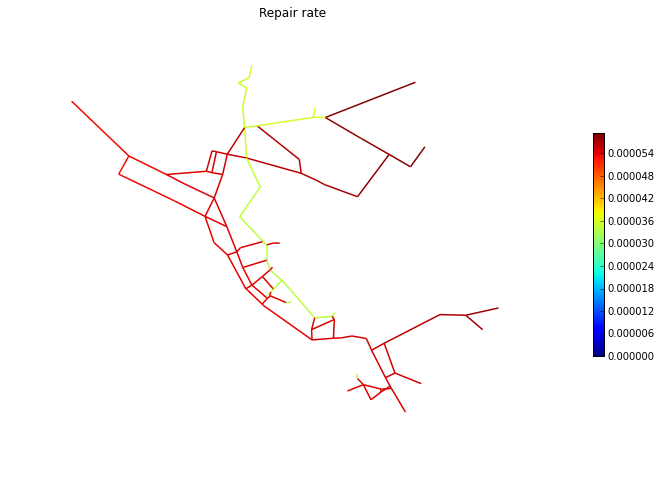

In [7]:
wntr.network.draw_graph(wn, link_attribute=earthquake.repair_rate, node_size=0, link_width=1.5, link_range=[0,np.max(earthquake.repair_rate.values())], title='Repair rate', figsize=(12,8), dpi=100)

#### Plot location of pipes with leaks

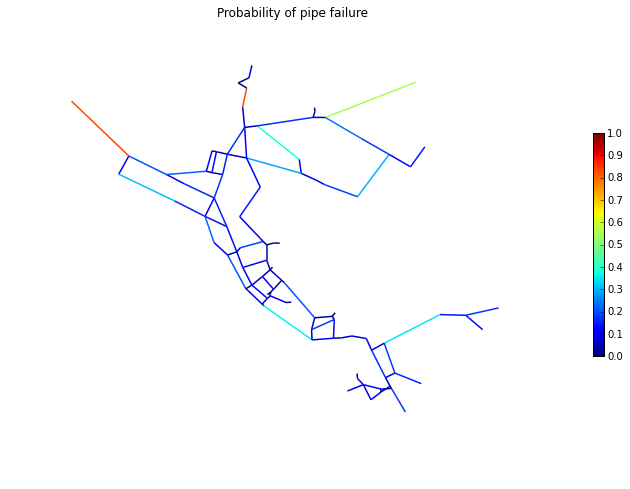

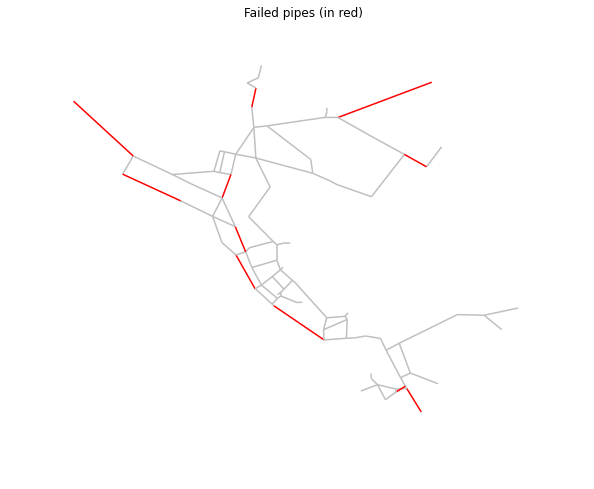

In [8]:
wntr.network.draw_graph(wn, link_attribute=earthquake.probability_of_leak, node_size=0, link_width=1.5, link_range=[0,1], title='Probability of pipe failure', figsize=(12,8), dpi=100)

gray_red_colormap = wntr.network.custom_colormap(2, colors = ['0.75','red'])
wntr.network.draw_graph(wn, link_attribute=earthquake.pipe_status, node_size=0, link_width=1.5, link_cmap=gray_red_colormap, link_range=[0,1], title='Failed pipes (in red)', add_colorbar=False, figsize=(10,8), dpi=100)

#### Add leaks to the model and simulate hydraulics

In [9]:
# The simulation uses pressure driven hydraulics and leak models to account for loss.
wn.set_nominal_pressures(constant_nominal_pressure = 15) 
wn.time_options['DURATION'] = 24*3600
wn.time_options['HYDRAULIC TIMESTEP'] = 600
wn.time_options['REPORT TIMESTEP'] = 600
sim = wntr.sim.PyomoSimulator(wn,'PRESSURE DRIVEN')

time_of_failure = 5 # time of failure
duration_of_failure = 20 # Select duration of failure     
for pipe_name in earthquake.pipes_to_leak:
    # Select leak diameter, uniform dist, between 0.01 and pipe diameter 
    pipe_diameter = wn.get_link(pipe_name).diameter
    leak_diameter = np.round(np.random.uniform(0.01,0.25*pipe_diameter,1), 2) 
    # Add pipe leak to the simulator
    sim.add_leak(leak_name = pipe_name, pipe_name = pipe_name, leak_diameter = leak_diameter[0], 
                 start_time = pd.Timedelta(time_of_failure, unit='h'), fix_time = pd.Timedelta(time_of_failure + duration_of_failure, unit='h'))
        
results = sim.run_sim(demo=False)
pickle.dump(results, open('demo.pickle', 'wb'))

Running Hydraulic Simulation at time 0 days 00:00:00  ... 
Running Hydraulic Simulation at time 0 days 00:10:00  ... 
Running Hydraulic Simulation at time 0 days 00:20:00  ... 
Running Hydraulic Simulation at time 0 days 00:30:00  ... 
Running Hydraulic Simulation at time 0 days 00:40:00  ... 
Running Hydraulic Simulation at time 0 days 00:50:00  ... 
Running Hydraulic Simulation at time 0 days 01:00:00  ... 
Running Hydraulic Simulation at time 0 days 01:10:00  ... 
Running Hydraulic Simulation at time 0 days 01:20:00  ... 
Running Hydraulic Simulation at time 0 days 01:30:00  ... 
Running Hydraulic Simulation at time 0 days 01:40:00  ... 
Running Hydraulic Simulation at time 0 days 01:50:00  ... 
Running Hydraulic Simulation at time 0 days 02:00:00  ... 
Running Hydraulic Simulation at time 0 days 02:10:00  ... 
Running Hydraulic Simulation at time 0 days 02:20:00  ... 
Running Hydraulic Simulation at time 0 days 02:30:00  ... 
Running Hydraulic Simulation at time 0 days 02:40:00  ..

#### Plot results

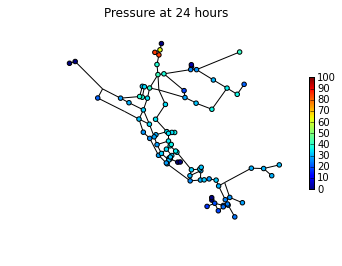

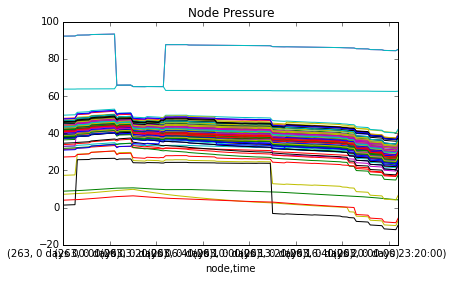

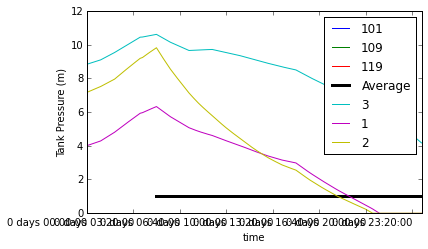

In [10]:
results = pickle.load(open('demo.pickle', 'rb'))

pressure_at_24hr = results.node.loc[(slice(None), pd.Timedelta(hours = 24)), 'pressure']
pressure_at_24hr = pressure_at_24hr.drop(earthquake.pipes_to_leak)
wntr.network.draw_graph(wn, node_attribute=pressure_at_24hr, node_size=20, node_range = [0,100], title='Pressure at 24 hours')

plt.figure()
for name, node in wn.nodes(wntr.network.Junction):
    pressure = results.node.loc[(name, slice(None)), 'pressure']
    pressure.plot()
plt.title("Node Pressure")
    
nzd_junctions = wn.query_node_attribute('base_demand', np.greater, 0.01, node_type=wntr.network.Junction).keys()  

# FDV, scenario k, time t
FDV_kt = results.node.loc[nzd_junctions, 'demand'].sum(level=1)/results.node.loc[nzd_junctions, 'expected_demand'].sum(level=1)
# FDV, scenario k, node n, time t
FDV_knt = results.node.loc[nzd_junctions, 'demand']/results.node.loc[nzd_junctions, 'expected_demand']

plt.figure()
FDV_knt = FDV_knt.unstack().T 
FDV_knt.index = FDV_knt.index.format() 
FDV_knt.plot(ax=plt.gca(), legend=False)
plt.hold(True)
FDV_kt.plot(ax=plt.gca(), label='Average', color='k', linewidth=3.0, legend=False)
plt.ylim( (-0.05, 1.05) )
plt.ylabel('FDV')

for tank_name, tank in wn.nodes(wntr.network.Tank):
    tank_pressure = results.node['pressure'][tank_name]
    tank_pressure.index = tank_pressure.index.format() 
    tank_pressure.plot(ax=plt.gca(),label=tank_name)
    plt.hold(True)
    
plt.ylim(ymin=0, ymax=12)
plt.legend()
plt.ylabel('Tank Pressure (m)')